# Experiment Run

Information Geometry Soft Clustering for Sport Analytics

Joaquin Garay

In [3]:
%load_ext autoreload
%autoreload 2

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

import vis
import softclustering as sc
import socceraction.spadl as spadl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [4]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")
    actions = sc.consolidate(actions)
    actions = sc.add_noise(actions)
    actions = sc.remove_outliers(actions, True)
    actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
    actions["cos_angle"] = np.cos(actions["angle"])
    actions["sin_angle"] = np.sin(actions["angle"])



64it [00:00, 179.00it/s]


Remove 532 out of 128484 datapoints.


## Experiment

There are 10 action types that are to be clustered using Gaussian mixture distribution. Some of the actions have not and end location, thus are not relevant for this research because we cannot compute their direction. Also the action "shot_penalty" always has the same start location, so no need to cluster them.

In [5]:
# select actions type to run location soft clustering
# shot penalty has always the same starting point
no_dir_action_types = set(actions[actions["angle"] == 0.0]["type_name"])
action_types = set(actions["type_name"]) - no_dir_action_types - {"shot_penalty"}
action_types

{'clearance',
 'corner',
 'cross',
 'dribble',
 'freekick',
 'goalkick',
 'keeper_action',
 'pass',
 'shot',
 'throw_in'}

### Location mixture: Number of clusters calibration

We look for the optimal number of location clusters for each action type based on a modified Calinski–Harabasz index for soft clustering.
$$CH = \frac{BC/(K-1)}{WC/(N-K)},$$
where between-cluster distance ($BC$) and within-cluster distance ($WC$) are defined as:
$$BC = \min_{\bar{\eta}}\sum_{j=1}^K \pi_j D_{\phi}[\eta_j : \bar{\eta}], \quad WC = -\sum_{i=1}^N\sum_{j=1}^K \ln (f(x_i|\theta_j)\cdot \pi_j) \, P(C_j|x_i).$$

In [6]:
rows = []
for action_type in action_types:
    print(f"\nProcessing {action_type}:")
    mask = (actions["type_name"] == action_type)  #& (actions["team_id"] == 771)
    loc_data = actions[mask][["start_x", "start_y"]]

    # Inner loop over number of clusters
    for K in range(2, 6):
        print(f" {K} clusters,", end="")
        gauss_clusters = [sc.MultivariateGaussian() for _ in range(K)]
        loc_model = sc.MixtureModel(gauss_clusters,
                                    init='k-means++')
        # In the case of an failed initialization due to empty clusters, skip that model.
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=ConvergenceWarning)
            try:
                loc_model.fit_em(loc_data, verbose=False, case="bregman")
            except ConvergenceWarning as e:
                print(f"    Skipping K={K} due to convergence warning: {e}")
                continue  # skip straight to the next K
        rows.append({
            "action_type": action_type,
            "cluster_nbr": K,
            "ch_score": round(loc_model.kl_ch_score(loc_data), 5),
            "bic_score": round(loc_model.bic_score(loc_data), 0),
            "aic_score": round(loc_model.aic_score(loc_data), 0)
        })

loc_scores = pd.DataFrame(rows)


Processing throw_in:
 2 clusters, 3 clusters, 4 clusters, 5 clusters,
Processing pass:
 2 clusters, 3 clusters, 4 clusters, 5 clusters,
Processing goalkick:
 2 clusters, 3 clusters, 4 clusters, 5 clusters,
Processing cross:
 2 clusters, 3 clusters, 4 clusters, 5 clusters,
Processing freekick:
 2 clusters, 3 clusters, 4 clusters, 5 clusters,
Processing shot:
 2 clusters, 3 clusters, 4 clusters, 5 clusters,
Processing corner:
 2 clusters, 3 clusters, 4 clusters, 5 clusters,
Processing keeper_action:
 2 clusters, 3 clusters, 4 clusters, 5 clusters,
Processing clearance:
 2 clusters, 3 clusters, 4 clusters, 5 clusters,
Processing dribble:
 2 clusters, 3 clusters, 4 clusters, 5 clusters,

In [7]:
loc_scores

,action_type,cluster_nbr,ch_score,bic_score,aic_score
0,throw_in,2,5.433461e+02,25556.0,25482.0
1,throw_in,3,2.703218e+02,25414.0,25300.0
2,throw_in,4,1.354157e+10,10561.0,10408.0
3,throw_in,5,2.742494e+10,5303.0,5110.0
4,pass,2,1.171000e-01,999051.0,998935.0
5,pass,3,5.123300e-01,984053.0,983874.0
6,pass,4,6.398200e-01,979393.0,979151.0
7,pass,5,4.859700e-01,978635.0,978331.0
8,goalkick,2,1.903600e-01,5260.0,5202.0
9,goalkick,3,4.109500e-01,5280.0,5190.0


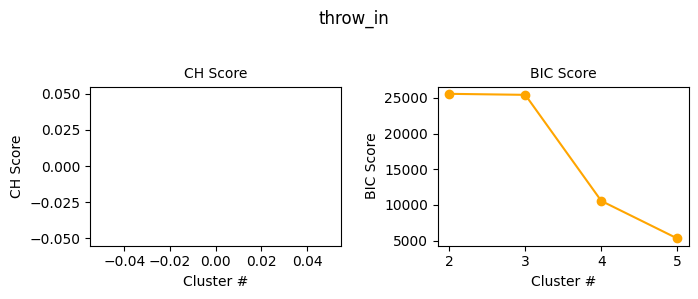

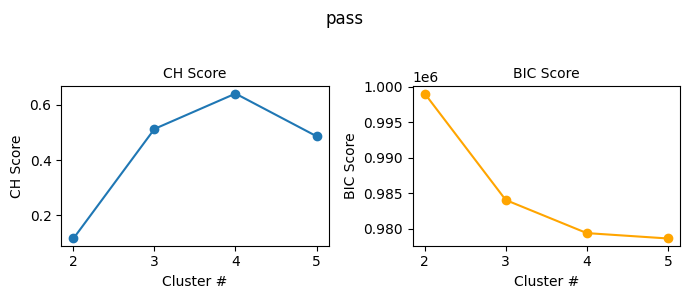

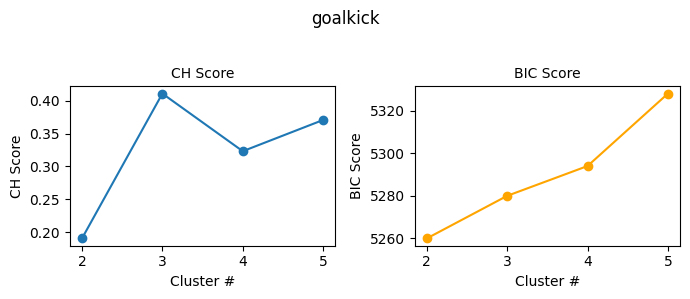

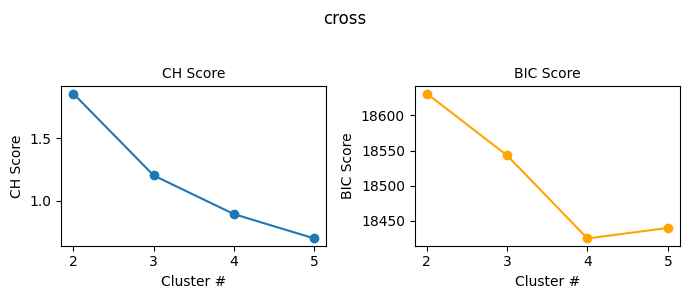

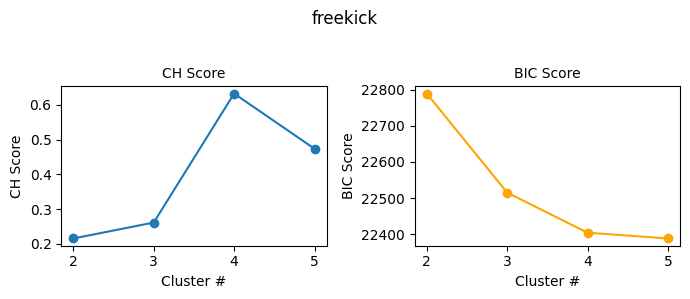

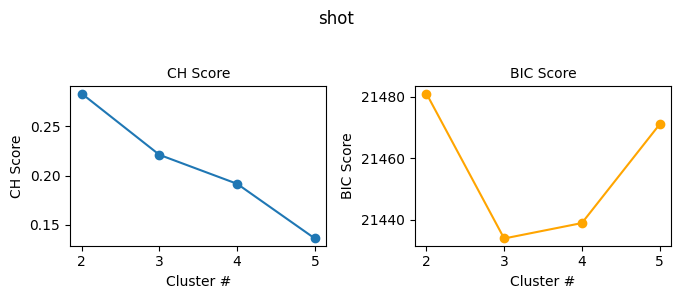

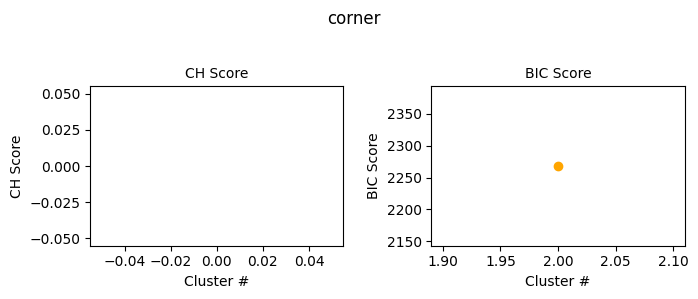

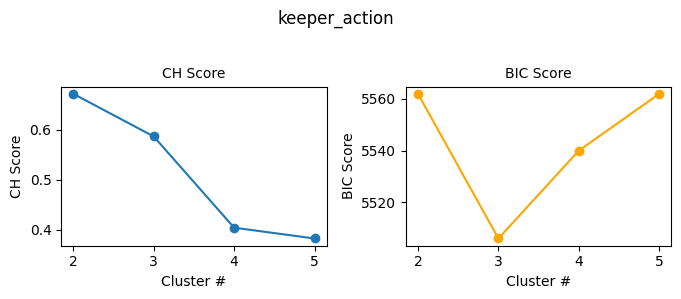

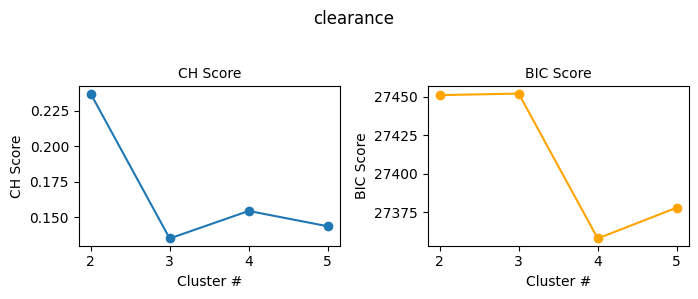

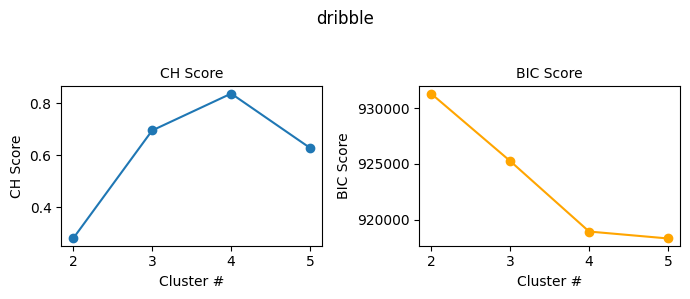

In [103]:
# Filter CH scores
loc_scores_filtered = loc_scores[(loc_scores["ch_score"] <= 2) & (loc_scores["ch_score"] > 0)]

# Loop through each action_type and make a (1,2) plot per type
for action_type in action_types:
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    fig.suptitle(f"{action_type}", fontsize=12)

    # CH Score subplot
    ch_data = loc_scores_filtered[loc_scores_filtered["action_type"] == action_type]
    axes[0].plot(ch_data["cluster_nbr"], ch_data["ch_score"], marker="o")
    axes[0].set_title("CH Score", fontsize=10)
    axes[0].set_xlabel("Cluster #")
    axes[0].set_ylabel("CH Score")

    # BIC Score subplot
    bic_data = loc_scores[(loc_scores["action_type"] == action_type) & (loc_scores["bic_score"] > 0)]
    axes[1].plot(bic_data["cluster_nbr"], bic_data["bic_score"], marker="o", color="orange")
    axes[1].set_title("BIC Score", fontsize=10)
    axes[1].set_xlabel("Cluster #")
    axes[1].set_ylabel("BIC Score")

    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
    plt.show()

In [9]:
optimal_loc_K = {
    f"{action_type}": group.loc[group["ch_score"].idxmax(), "cluster_nbr"]
    for action_type, group in loc_scores_filtered.groupby("action_type")
}
optimal_loc_K

{'clearance': 2,
 'cross': 2,
 'dribble': 4,
 'freekick': 4,
 'goalkick': 3,
 'keeper_action': 2,
 'pass': 4,
 'shot': 2}

In [10]:
optimal_loc_K = {
    'clearance': 2,
    'cross': 2,
    'dribble': 4,
    'freekick': 2,
    'goalkick': 2,
    'keeper_action': 2,
    'pass': 4,
    'shot': 2,
    'throw_in': 4,  #manually added
    'corner': 2  #manually added
}

In [11]:
loc_models = {}
for action_type in action_types:
    print(f"Processing {action_type}...")
    mask = (actions["type_name"] == action_type)
    loc_data = actions[mask][["start_x", "start_y"]]
    loc_K = optimal_loc_K[action_type]
    gauss_clusters = [sc.MultivariateGaussian() for _ in range(loc_K)]
    loc_model = sc.MixtureModel(gauss_clusters,
                                init='k-means++')
    _ = loc_model.fit_em(loc_data, case="bregman")
    loc_models[action_type] = loc_model

Processing throw_in...
Processing pass...
Processing goalkick...
Processing cross...
Processing freekick...
Processing shot...
Processing corner...
Processing keeper_action...
Processing clearance...
Processing dribble...


In [12]:
print(loc_models["pass"])

MixtureModel(n_components=4)
  ├─ (0) w=0.431  MultivariateGaussian(d=2, mean=[49.71  20.491], cov=[[480.171 -40.79 ], [-40.79   88.726]])
  ├─ (1) w=0.072  MultivariateGaussian(d=2, mean=[56.153 64.903], cov=[[433.059   0.246], [0.246 1.826]])
  ├─ (2) w=0.079  MultivariateGaussian(d=2, mean=[56.713  3.255], cov=[[429.73   -1.456], [-1.456  2.348]])
  └─ (3) w=0.418  MultivariateGaussian(d=2, mean=[50.55  48.752], cov=[[471.947  33.126], [33.126 77.334]])


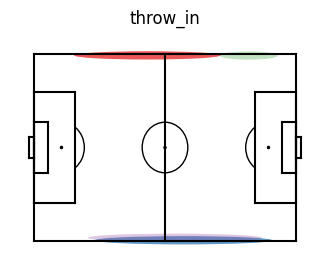

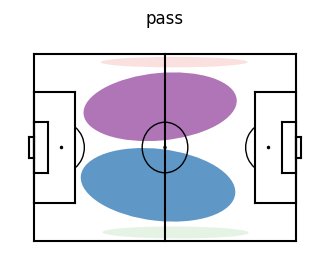

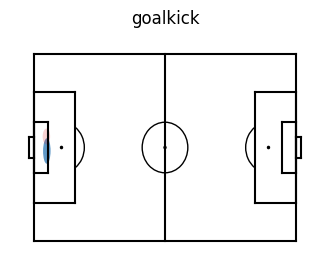

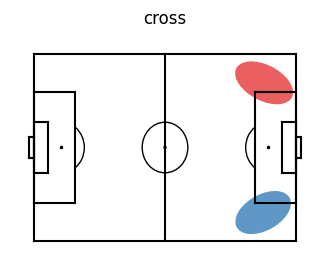

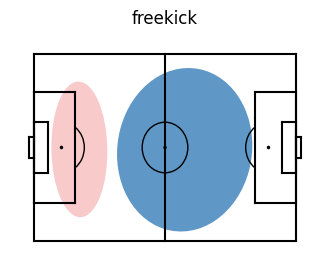

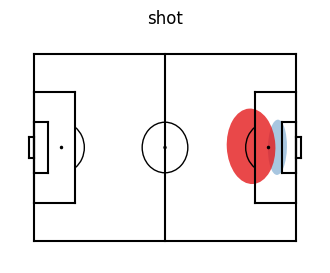

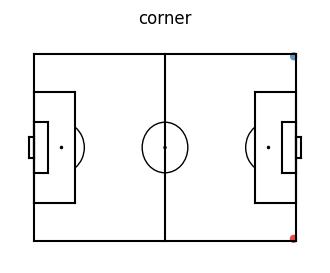

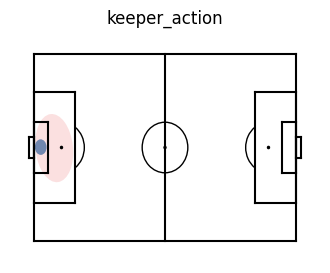

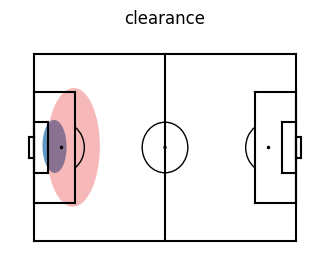

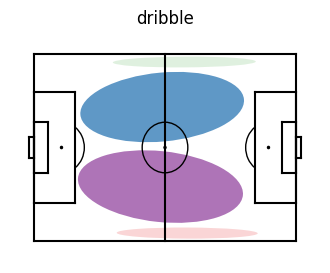

In [13]:
for action_type in action_types:
    vis.show_location_model(loc_models[action_type], figsize=4, title=action_type)

### Direction mixture: Number of cluster calibration

Similarly, we continue searching for the optimal number of cluster for the direction mixture mddel. In this case, we model a von Mises mixture distribution for each location cluster for each action type. The direction data is the full dataset as before, but weighted by the location posteriors probabilities of each cluster.

In [16]:
def dir_calibration(actions, action_types, loc_models):
    rows = []
    for action_type in action_types:
        print(f"\nProcessing {action_type}:")
        mask = (actions["type_name"] == action_type)
        loc_data = actions[mask][["start_x", "start_y"]]
        dir_data = actions[mask][["cos_angle", "sin_angle"]]
        N = loc_data.shape[0]
        loc_model = loc_models[action_type]
        K_loc = loc_model.n_components
        # first layer posterior is fixed
        loc_posteriors = loc_model.get_posteriors(loc_data)
        for case in ["bregman", "classic", "approximation"]:
            print(f"   Approach: {case}")
            for loc_cluster in range(K_loc):
                print(f"      Location cluster: {loc_cluster}\n         ", end="")
                for K_dir in range(2, 6):
                    print(f"K={K_dir}, ", end="")
                    start = time()
                    dir_mixture = sc.MixtureModel([sc.VonMises() for _ in range(K_dir)],
                                                  weights=None,
                                                  init="k-means++")
                    _ = dir_mixture.fit_em(dir_data,
                                           sample_weight=loc_posteriors[:, loc_cluster],
                                           case=case)
                    end = time() - start

                    rows.append({
                        "action_type": action_type,
                        "loc_cluster": loc_cluster,
                        "cluster_nbr": K_dir,
                        "model": case,
                        "ch_score": round(dir_mixture.kl_ch_score(dir_data), 5),
                        "bic_score": round(dir_mixture.bic_score(dir_data), 0),
                        "aic_score": round(dir_mixture.aic_score(dir_data), 0),
                        "running_time": round(end, 3)
                    })
                print("")

    dir_scores = pd.DataFrame(rows)
    return dir_scores

In [17]:
dir_scores = dir_calibration(actions, action_types, loc_models)


Processing throw_in:
   Approach: bregman
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
         K=2, K=3, K=4, K=5, 
      Location cluster: 3
         K=2, K=3, K=4, K=5, 
   Approach: classic
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
         K=2, K=3, K=4, K=5, 
      Location cluster: 3
         K=2, K=3, K=4, K=5, 
   Approach: approximation
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
         K=2, K=3, K=4, K=5, 
      Location cluster: 3
         K=2, K=3, K=4, K=5, 

Processing pass:
   Approach: bregman
      Location cluster: 0
         K=2, K=3, K=4, K=5, 
      Location cluster: 1
         K=2, K=3, K=4, K=5, 
      Location cluster: 2
         K=2, K=3, K=4, K=5, 
      Location cluster: 3
    

In [18]:
dir_scores

,action_type,loc_cluster,cluster_nbr,model,ch_score,bic_score,aic_score,running_time
0,throw_in,0,2,bregman,0.25133,11760.0,11743.0,0.040
1,throw_in,0,3,bregman,0.14505,16132.0,16109.0,0.083
2,throw_in,0,4,bregman,0.10091,16102.0,16074.0,0.567
3,throw_in,0,5,bregman,0.06987,16110.0,16076.0,0.555
4,throw_in,1,2,bregman,0.30601,12179.0,12162.0,0.022
...,...,...,...,...,...,...,...,...
307,dribble,2,5,approximation,0.05248,198777.0,198724.0,13.486
308,dribble,3,2,approximation,0.02142,188817.0,188791.0,7.374
309,dribble,3,3,approximation,0.02960,188553.0,188518.0,6.966
310,dribble,3,4,approximation,0.02492,188549.0,188505.0,11.177


In [19]:
best_scores = dir_scores.loc[
    dir_scores.groupby(["action_type", "loc_cluster", "model"])["ch_score"].idxmax()
]
optimal_dir_K = best_scores[["action_type", "loc_cluster", "model", "cluster_nbr"]]
best_scores.sort_values(by=["action_type", "loc_cluster", "ch_score"], ascending=[True, True, False], inplace=True)
best_scores

,action_type,loc_cluster,cluster_nbr,model,ch_score,bic_score,aic_score,running_time
256,clearance,0,2,approximation,0.22244,6113.0,6096.0,0.179
248,clearance,0,2,classic,0.21951,6111.0,6094.0,0.846
240,clearance,0,2,bregman,0.21810,6111.0,6094.0,0.368
253,clearance,1,3,classic,0.13850,6110.0,6087.0,1.381
245,clearance,1,3,bregman,0.12240,6108.0,6086.0,0.392
...,...,...,...,...,...,...,...,...
8,throw_in,2,2,bregman,0.17907,13503.0,13486.0,0.025
24,throw_in,2,2,classic,0.17904,13547.0,13530.0,0.065
12,throw_in,3,2,bregman,0.31365,11515.0,11498.0,0.032
44,throw_in,3,2,approximation,0.31326,11985.0,11968.0,0.041


In [22]:
 # Run using optimal number of clusters
experiment = {}
rows = []
for method in ["bregman", "approximation", "classic"]:
    for init in ["k-means++", "k-means", "random", "random_from_data"]:
        dir_models = {}
        for action_type in action_types:
            mask = (actions["type_name"] == action_type)
            loc_data = actions[mask][["start_x", "start_y"]]
            dir_data = actions[mask][["cos_angle", "sin_angle"]]
            #N = loc_data.shape[0]
            loc_model = loc_models[action_type]
            K_loc = loc_model.n_components
            # first layer posterior is fixed
            loc_posteriors = loc_model.get_posteriors(loc_data)
            mixture_list = []
            for loc_cluster in range(K_loc):
                K_dir = optimal_dir_K[
                    (optimal_dir_K["action_type"] == action_type) &
                    (optimal_dir_K["loc_cluster"] == loc_cluster) &
                    (optimal_dir_K["model"] == method)]["cluster_nbr"].item()
                start = time()
                dir_mixture = sc.MixtureModel([sc.VonMises() for _ in range(K_dir)],
                                              weights=None,
                                              init=init)
                _ = dir_mixture.fit_em(dir_data,
                                       sample_weight=loc_posteriors[:, loc_cluster],
                                       case=method)
                end = round(time() - start, 3)
                mixture_list.append(dir_mixture)
                ch_score = round(dir_mixture.kl_ch_score(dir_data), 5)
                bic_score = round(dir_mixture.bic_score(dir_data), 0)
                aic_score = round(dir_mixture.aic_score(dir_data), 0)
                row = {
                    "action_type": action_type,
                    "loc_cluster": loc_cluster,
                    "model": method,
                    "initialization": init,
                    "n_components": K_dir,
                    "ch_score": ch_score,
                    "bic_score": bic_score,
                    "aic_score": aic_score,
                    "running_time": end
                }
                print(
                    f"{action_type}, {loc_cluster}, {method}, {init}, {K_dir}, {ch_score}, {bic_score}, {aic_score}, Time: {end}s")
                rows.append(row)

            dir_models[action_type] = mixture_list
        experiment[method + "," + init] = dir_models

experiment_df = pd.DataFrame(rows)

throw_in, 0, bregman, k-means++, 2, 0.25133, 11760.0, 11743.0, Time: 0.045s
throw_in, 1, bregman, k-means++, 2, 0.30601, 12179.0, 12162.0, Time: 0.021s
throw_in, 2, bregman, k-means++, 2, 0.17907, 13503.0, 13486.0, Time: 0.023s
throw_in, 3, bregman, k-means++, 2, 0.31365, 11515.0, 11498.0, Time: 0.053s
pass, 0, bregman, k-means++, 2, 0.13358, 206333.0, 206306.0, Time: 8.721s
pass, 1, bregman, k-means++, 2, 0.24525, 275491.0, 275464.0, Time: 2.841s
pass, 2, bregman, k-means++, 2, 0.2177, 263921.0, 263894.0, Time: 5.004s
pass, 3, bregman, k-means++, 2, 0.1421, 206633.0, 206607.0, Time: 8.24s
goalkick, 0, bregman, k-means++, 3, 0.32111, 1104.0, 1086.0, Time: 0.037s
goalkick, 1, bregman, k-means++, 3, 0.30775, 1211.0, 1193.0, Time: 0.036s
cross, 0, bregman, k-means++, 2, 0.0, 22745.0, 22730.0, Time: 0.062s
cross, 1, bregman, k-means++, 2, 0.00637, 22157.0, 22142.0, Time: 0.293s
freekick, 0, bregman, k-means++, 5, 0.1176, 4163.0, 4132.0, Time: 0.324s
freekick, 1, bregman, k-means++, 3, 0.12

In [23]:
experiment_df

,action_type,loc_cluster,model,initialization,n_components,ch_score,bic_score,aic_score,running_time
0,throw_in,0,bregman,k-means++,2,0.25133,11760.0,11743.0,0.045
1,throw_in,1,bregman,k-means++,2,0.30601,12179.0,12162.0,0.021
2,throw_in,2,bregman,k-means++,2,0.17907,13503.0,13486.0,0.023
3,throw_in,3,bregman,k-means++,2,0.31365,11515.0,11498.0,0.053
4,pass,0,bregman,k-means++,2,0.13358,206333.0,206306.0,8.721
...,...,...,...,...,...,...,...,...,...
307,clearance,1,classic,random_from_data,3,0.13850,6110.0,6087.0,1.429
308,dribble,0,classic,random_from_data,4,0.09270,188506.0,188462.0,19.034
309,dribble,1,classic,random_from_data,2,0.15226,199497.0,199470.0,9.346
310,dribble,2,classic,random_from_data,2,0.16518,198243.0,198217.0,9.530


In [40]:
dir_summary = experiment_df.groupby(["action_type", "model", "initialization"]).agg({"ch_score": "sum",
                                                                                     "loc_cluster": "count",
                                                                                     "n_components": "sum",
                                                                                     "bic_score": "sum",
                                                                                     "aic_score": "sum",
                                                                                     "running_time": "sum"})
dir_summary = dir_summary.reset_index()
dir_summary["ch_score"] = dir_summary["ch_score"].round(5)
dir_summary["running_time"] = dir_summary["running_time"].round(2)
dir_summary.rename(columns={"loc_cluster": "count_loc_clusters",
                            "n_components": "count_dir_clusters"},
                   inplace=True)
dir_summary.sort_values(by=["action_type", "ch_score"],
                        ascending=[True, False],
                        inplace=True)

In [41]:
dir_summary[dir_summary["action_type"] == "pass"]

,action_type,model,initialization,ch_score,count_loc_clusters,count_dir_clusters,bic_score,aic_score,running_time
92,pass,classic,k-means,0.74130,4,8,953710.0,953605.0,37.10
93,pass,classic,k-means++,0.74130,4,8,953710.0,953605.0,39.81
94,pass,classic,random,0.74130,4,8,953710.0,953605.0,35.73
95,pass,classic,random_from_data,0.74130,4,8,953710.0,953605.0,38.62
84,pass,approximation,k-means,0.73969,4,14,962544.0,962383.0,35.84
85,pass,approximation,k-means++,0.73969,4,14,962544.0,962383.0,34.85
87,pass,approximation,random_from_data,0.73969,4,14,962544.0,962383.0,39.22
88,pass,bregman,k-means,0.73863,4,8,952378.0,952271.0,24.77
89,pass,bregman,k-means++,0.73863,4,8,952378.0,952271.0,24.81
90,pass,bregman,random,0.73863,4,8,952378.0,952271.0,23.99


In [95]:
def bar_plot_results(df, score):
    model_colors = {
        "classic": "steelblue",
        "approximation": "orange",
        "bregman": "green",
    }

    for action_type in df["action_type"].unique():
        # Filter and set index
        df_filtered = df[df["action_type"] == action_type]
        df_filtered = df_filtered.set_index("model").sort_index()

        # Extract model level from MultiIndex for coloring
        models = df_filtered.index.get_level_values("model")
        bar_colors = [model_colors.get(model, "gray") for model in models]
        df_filtered.reset_index(inplace=True)
        df_filtered = df_filtered.set_index(["initialization"])
        # Plot
        ax = df_filtered[score].plot(
            kind="bar",
            figsize=(6, 4),
            title=f"{action_type} - {score} by Model and Initialization",
            rot=60,
            color=bar_colors
        )

        ax.set_ylabel(score)
        ax.set_xlabel("")
        ax.set_ylim(df_filtered[score].min()*0.95, df_filtered[score].max()*1.05)

        # Add custom legend
        handles = [plt.Line2D([0], [0], color=color, lw=4) for color in model_colors.values()]
        labels = model_colors.keys()
        ax.legend(handles, labels, title="Model",loc="lower right")

        plt.tight_layout()
        plt.show()

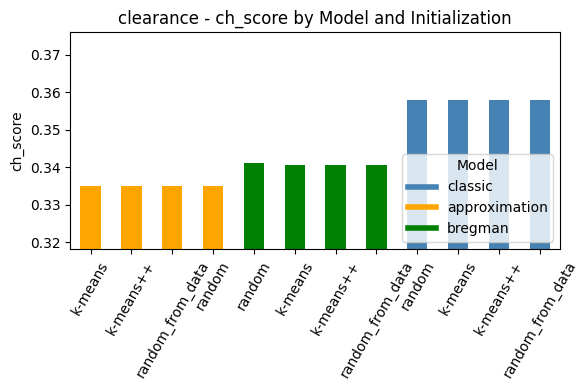

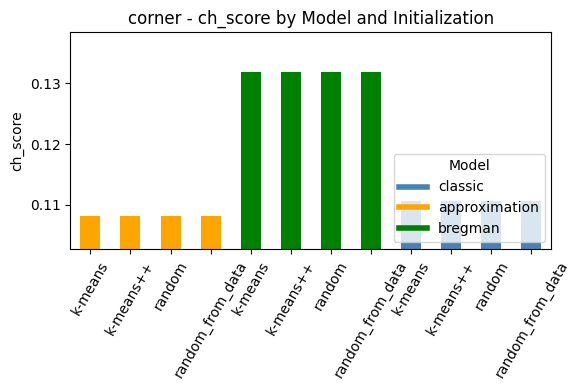

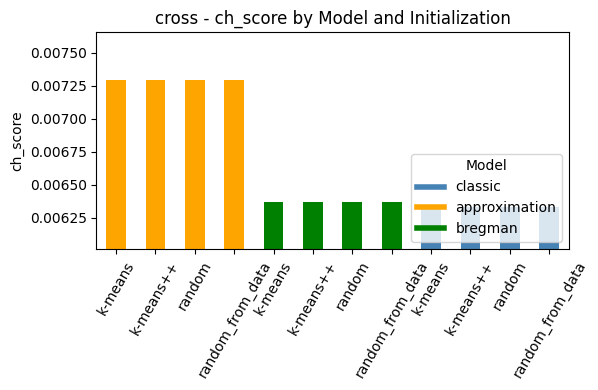

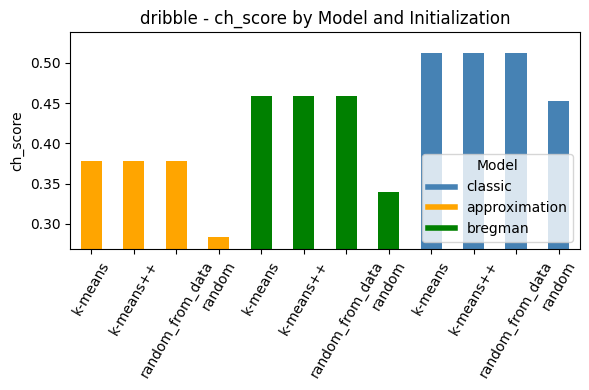

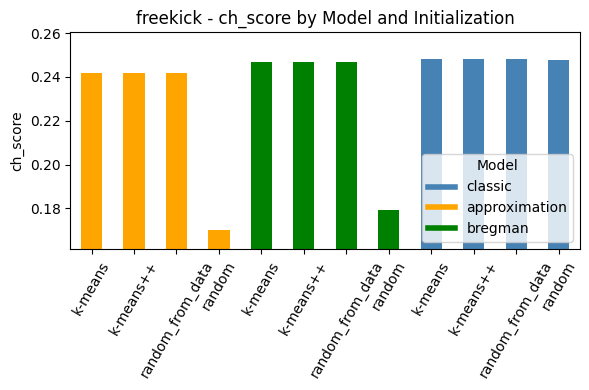

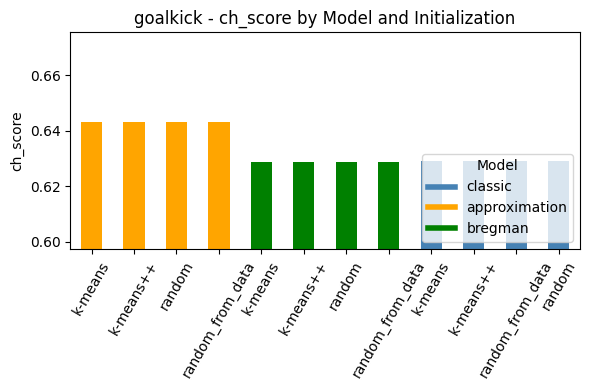

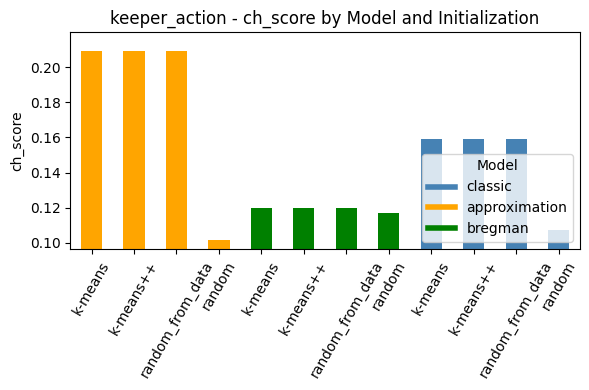

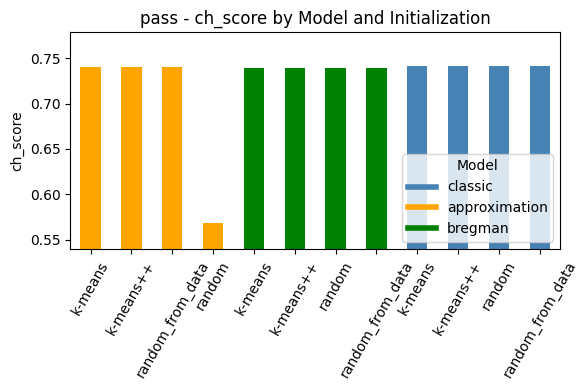

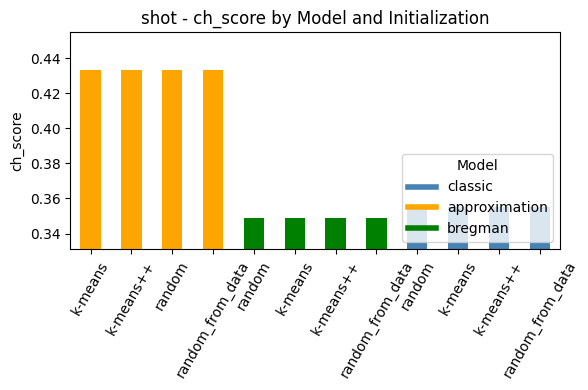

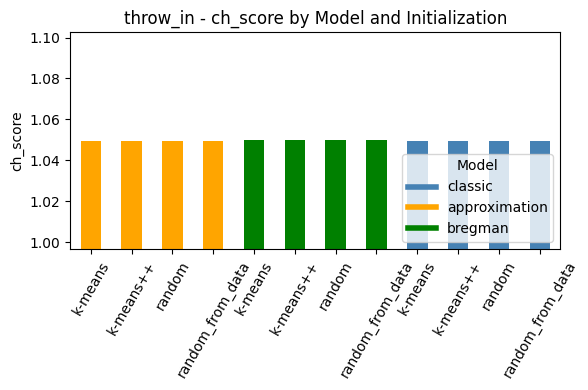

In [96]:
bar_plot_results(dir_summary, "ch_score")

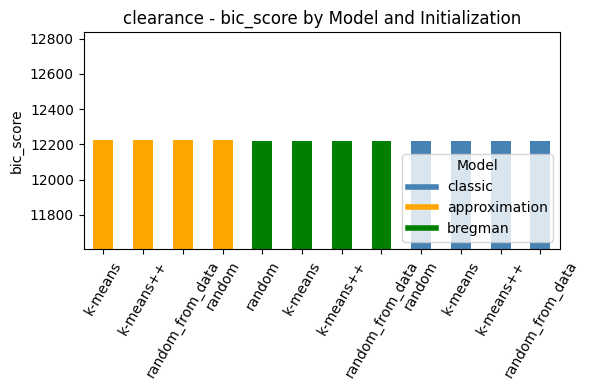

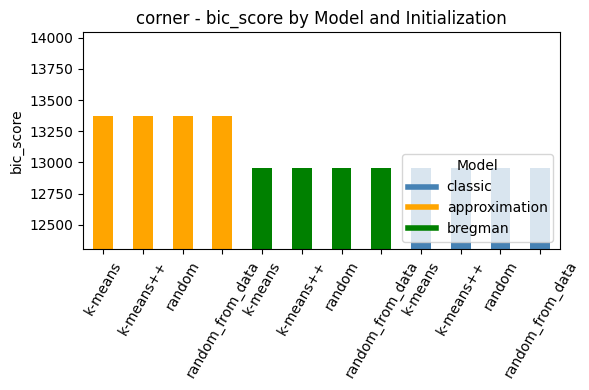

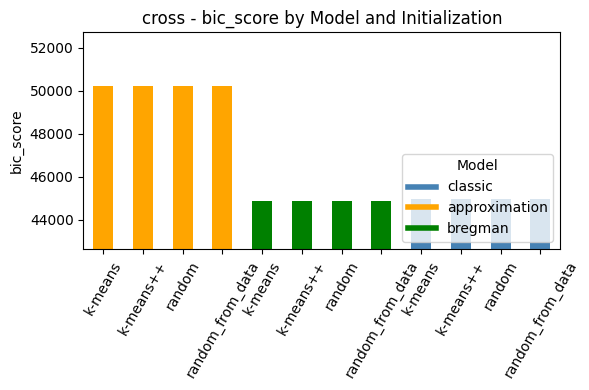

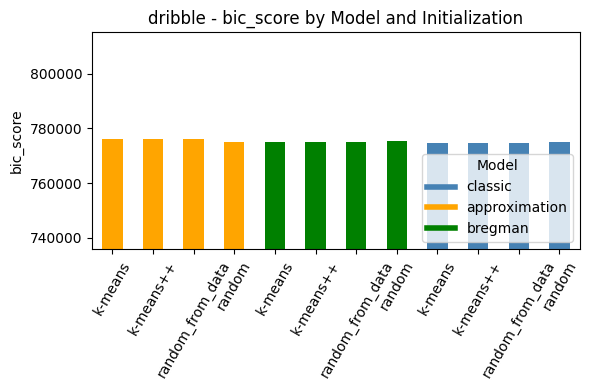

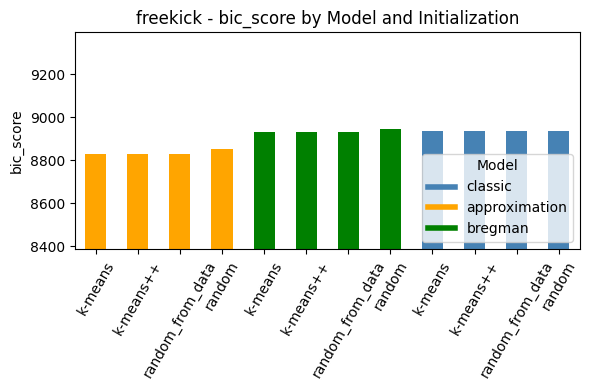

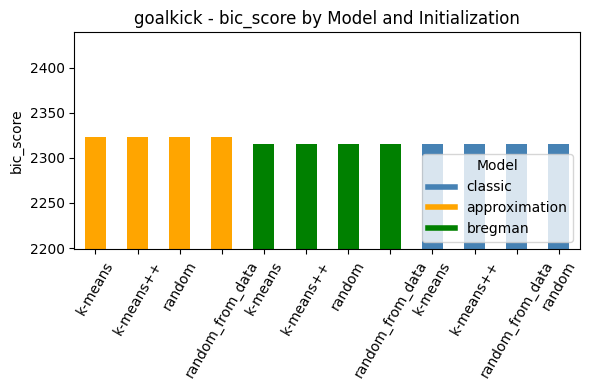

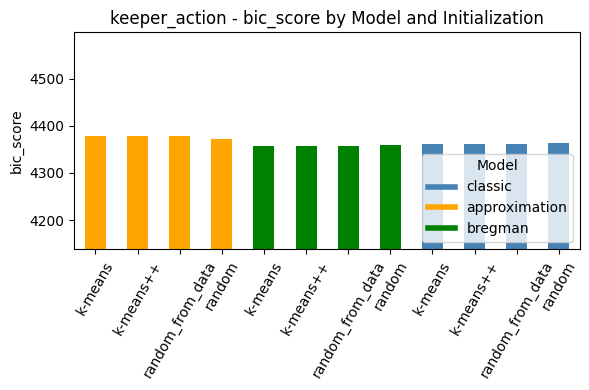

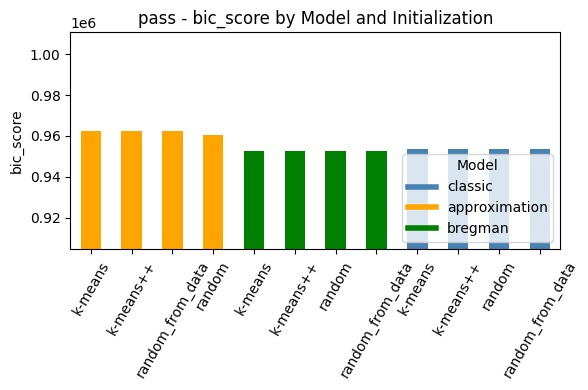

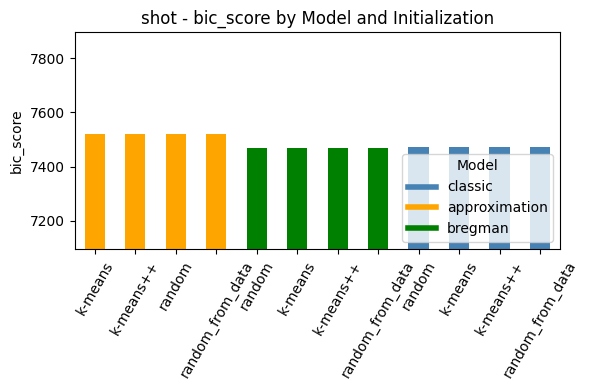

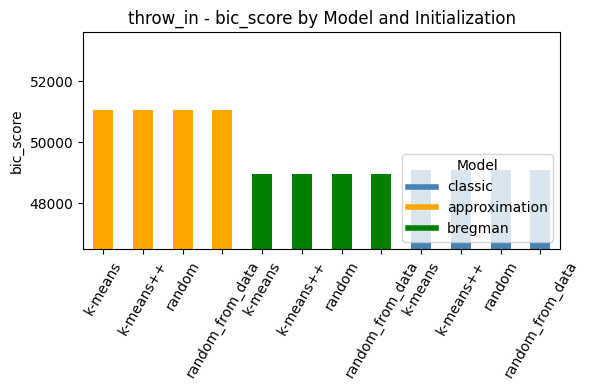

In [97]:
bar_plot_results(dir_summary, "bic_score")

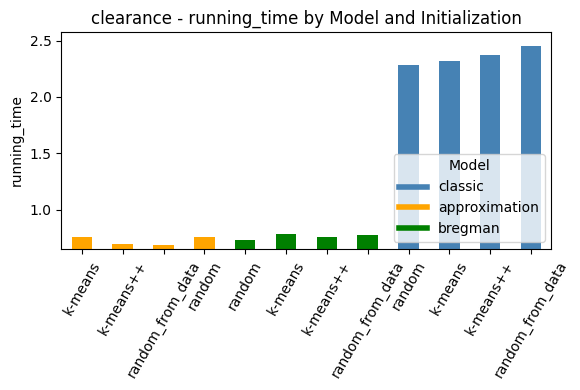

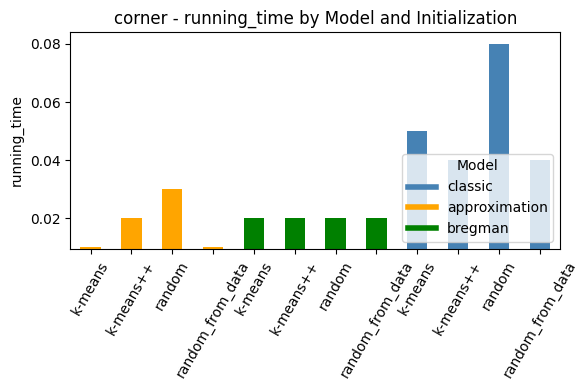

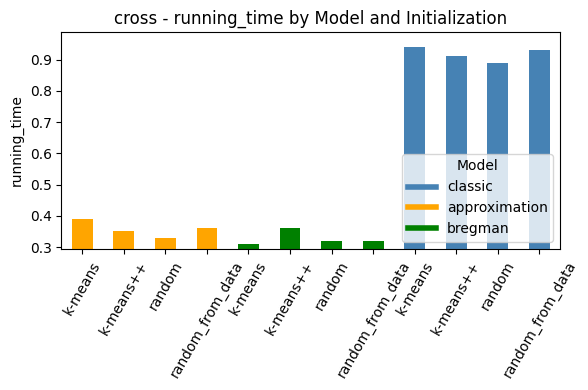

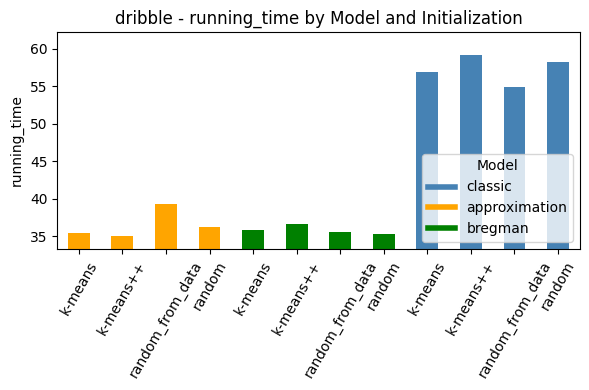

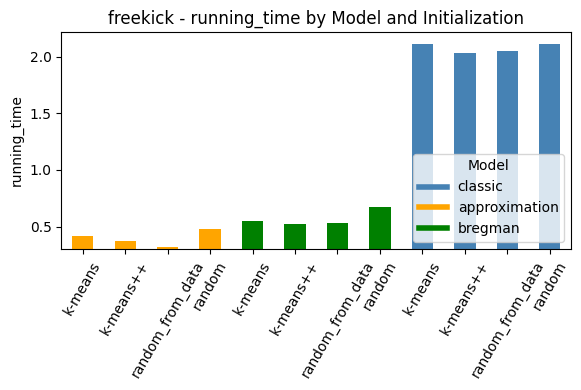

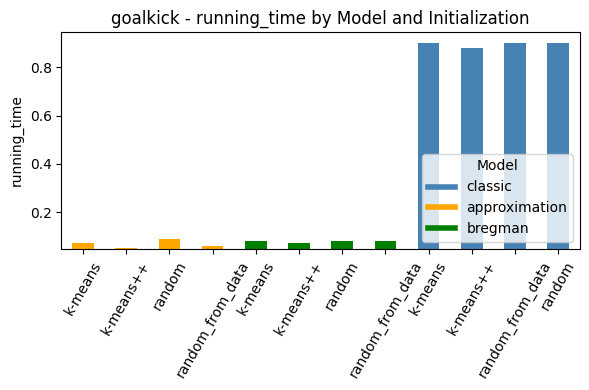

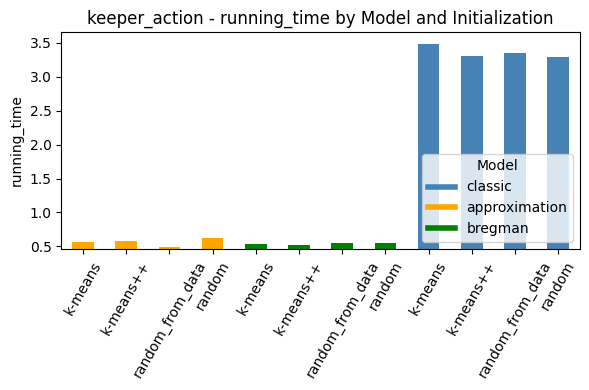

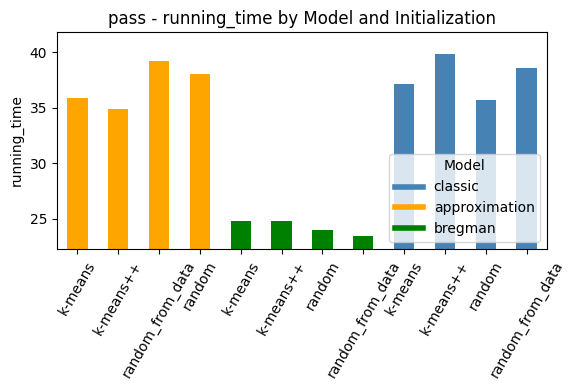

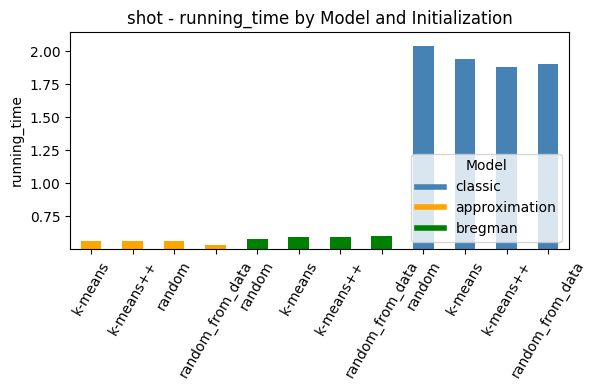

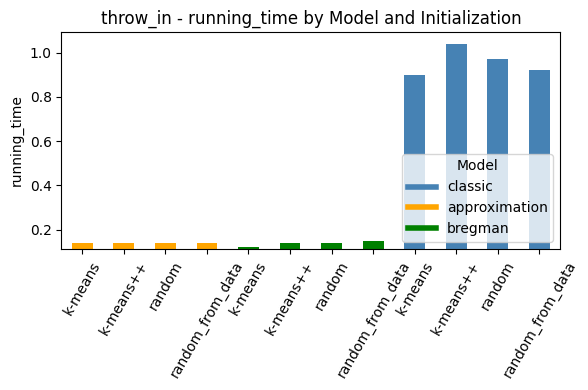

In [98]:
bar_plot_results(dir_summary, "running_time")

In [88]:
df = dir_summary.groupby(["model"]).sum().drop(columns=["action_type", "initialization"])
df.sort_values(by="ch_score", ascending=False, inplace=True)
df


,ch_score,count_loc_clusters,count_dir_clusters,bic_score,aic_score,running_time
model,,,,,,
classic,16.56441,104,264,7483130.0,7480852.0,430.91
approximation,16.13558,104,308,7551933.0,7549301.0,305.52
bregman,16.09185,104,268,7477900.0,7475604.0,252.52


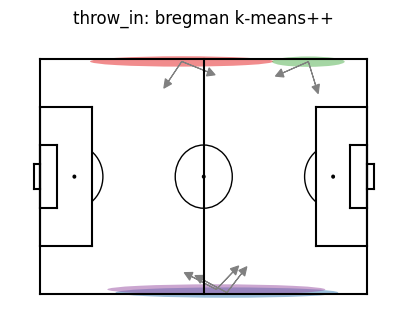

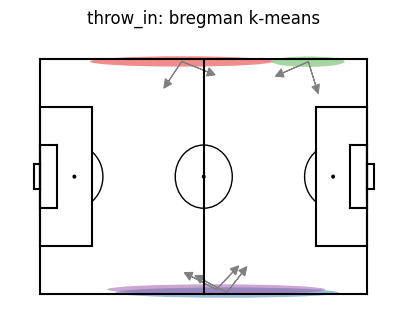

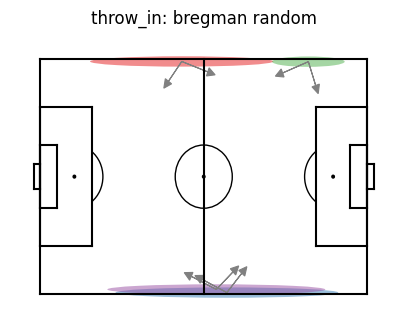

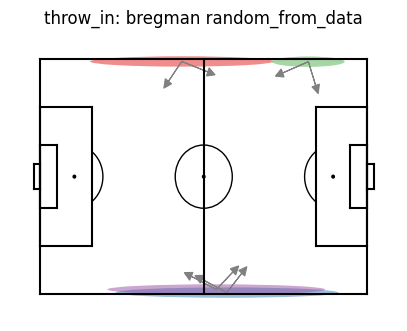

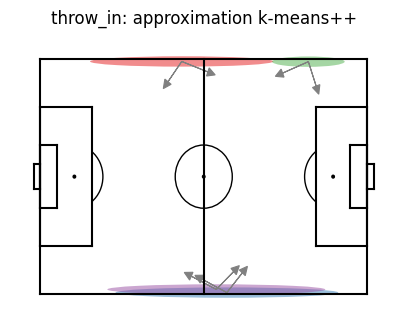

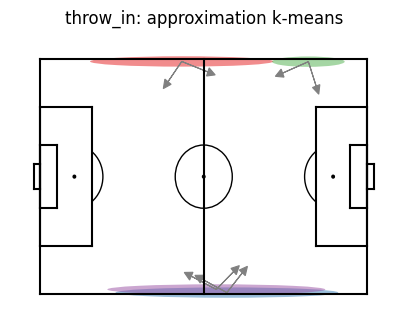

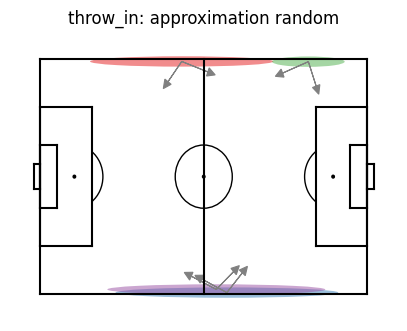

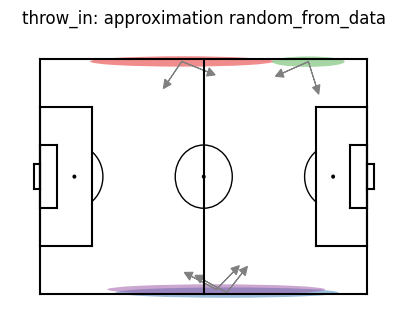

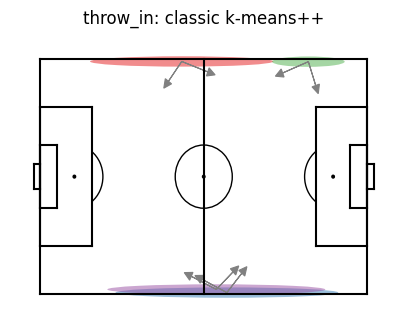

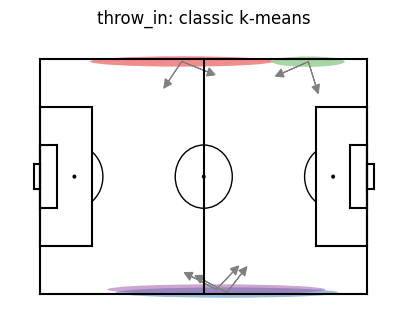

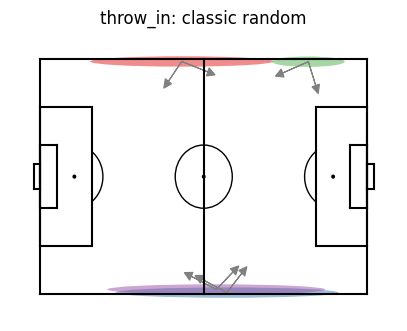

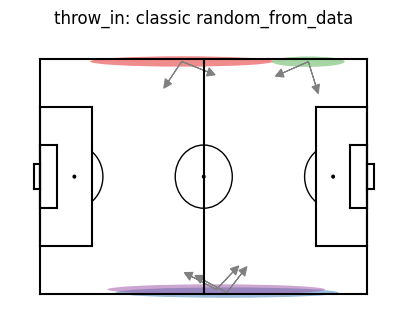

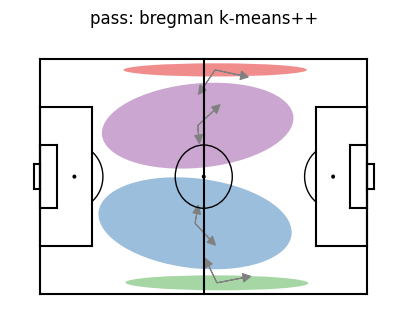

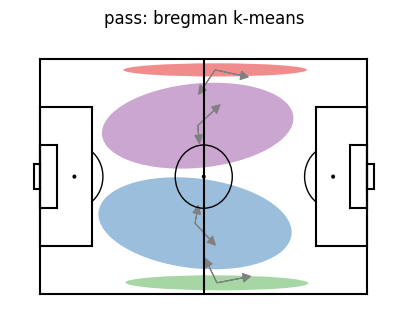

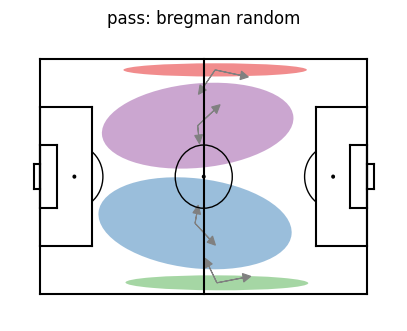

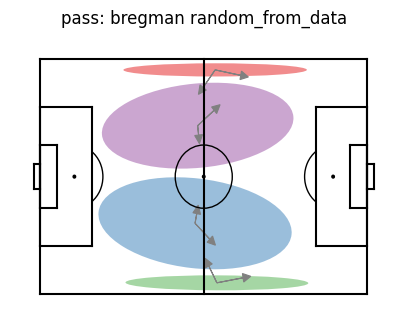

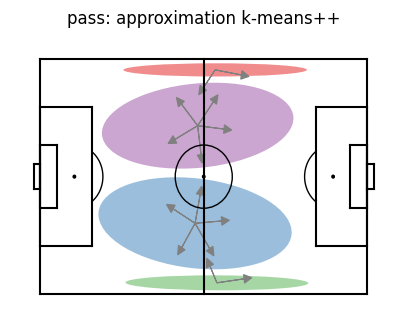

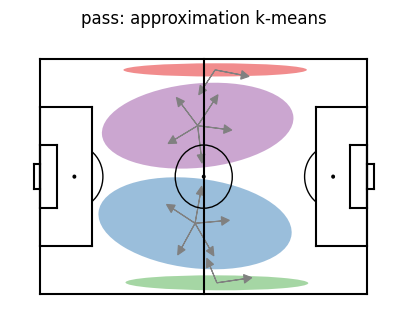

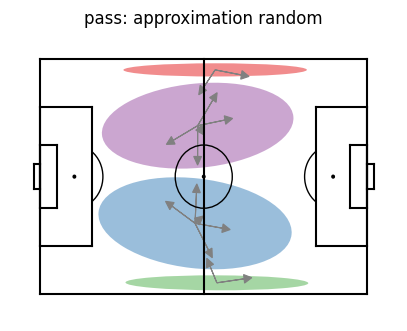

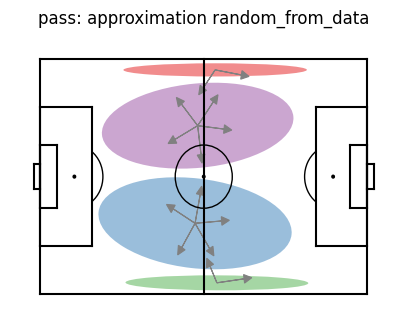

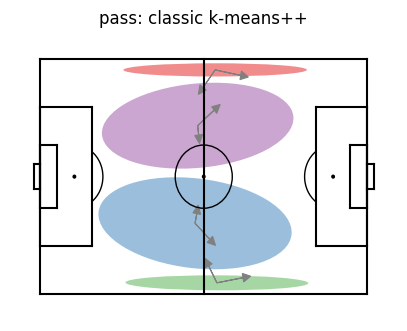

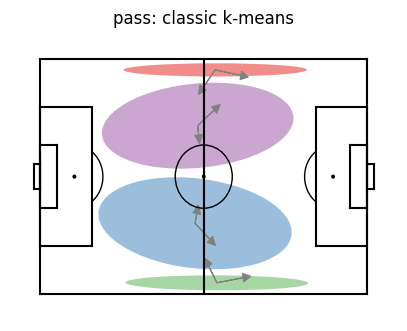

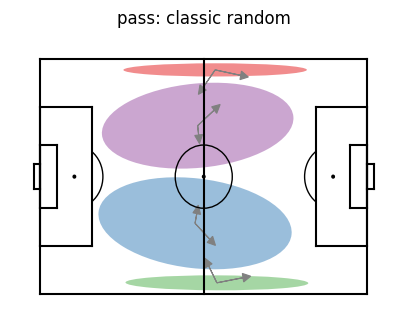

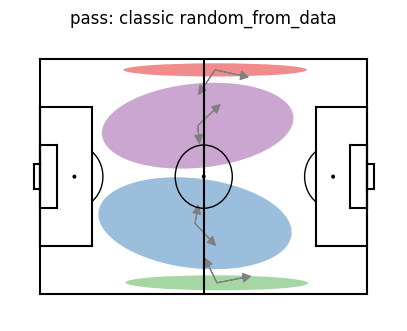

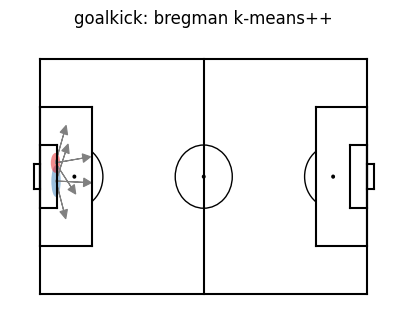

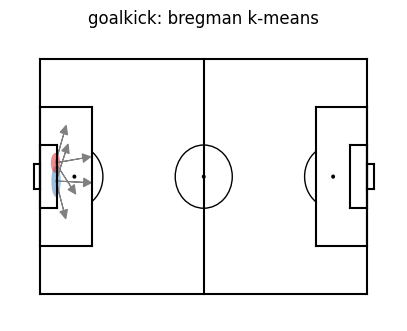

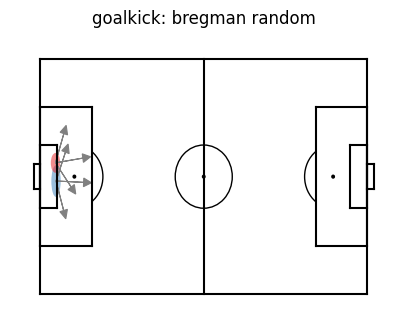

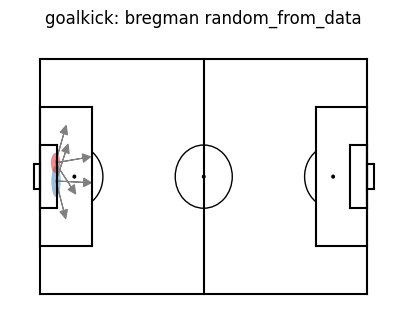

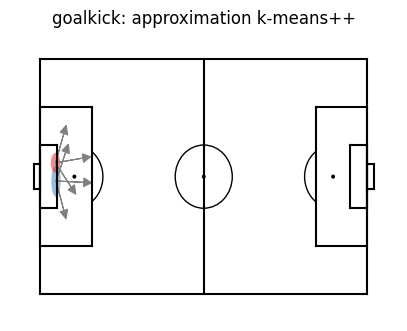

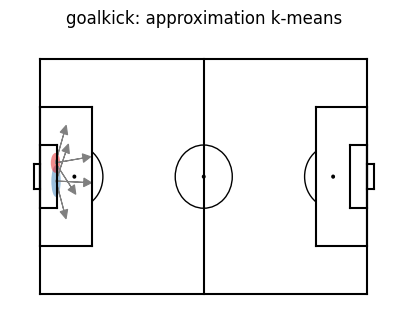

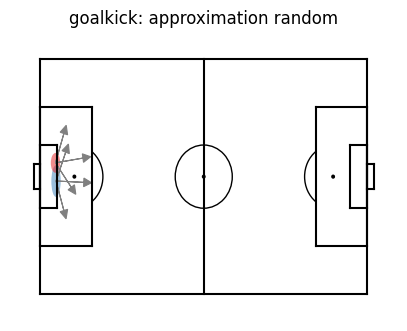

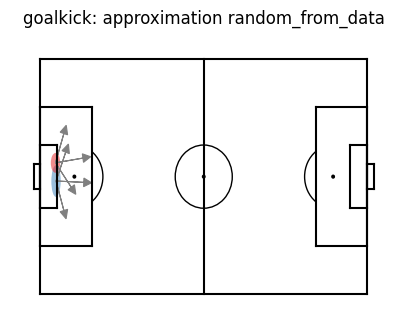

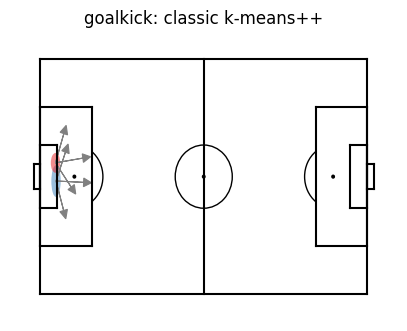

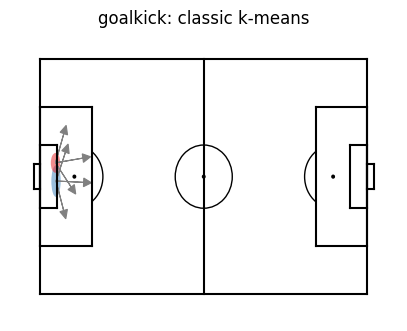

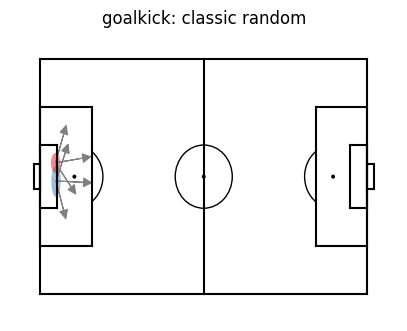

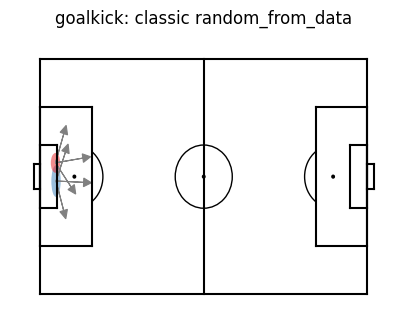

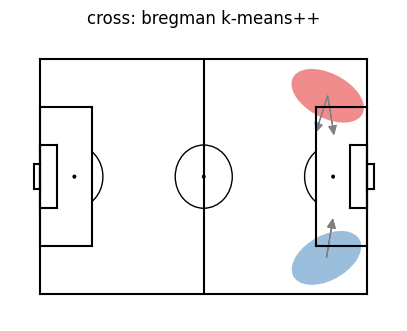

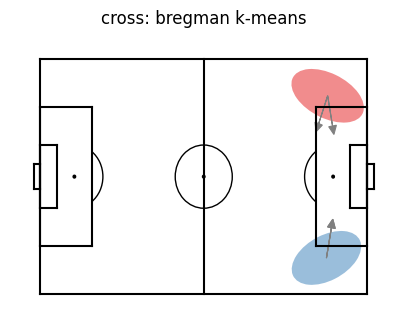

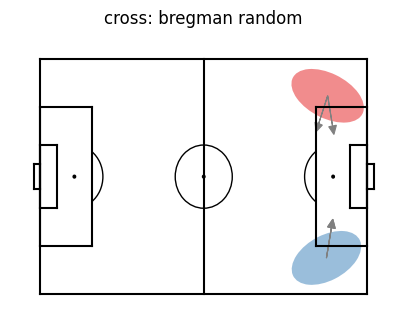

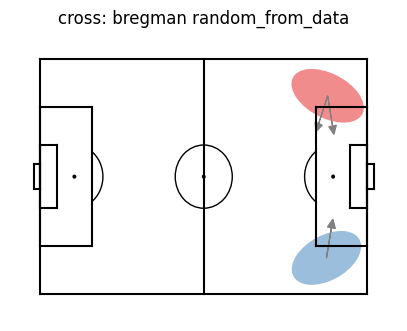

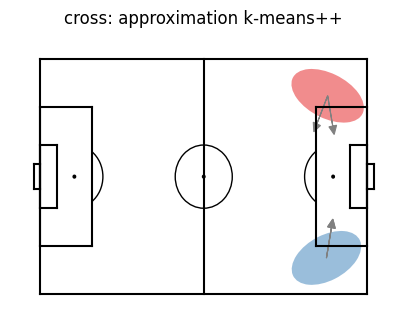

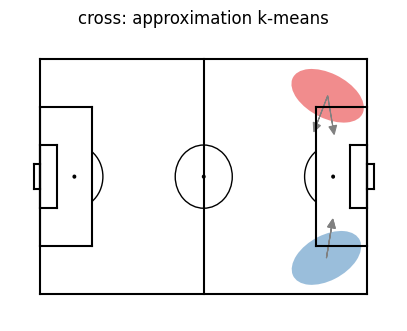

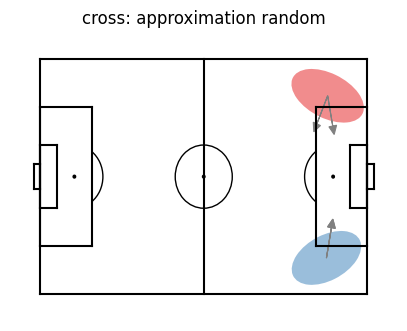

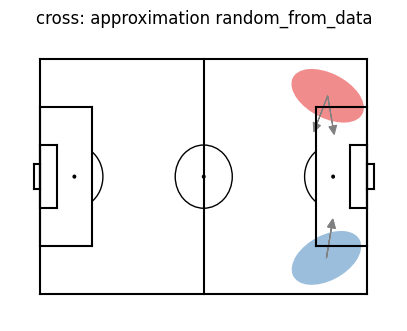

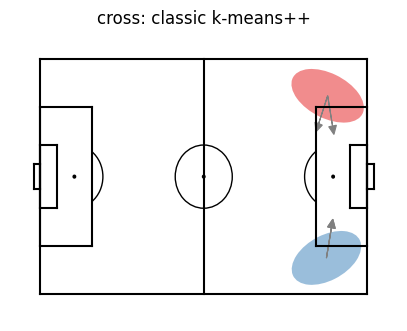

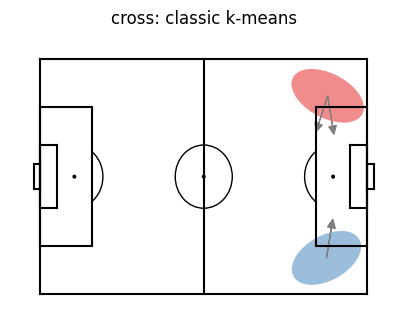

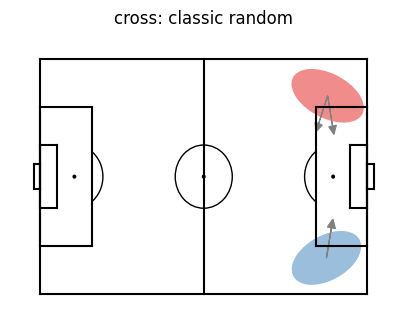

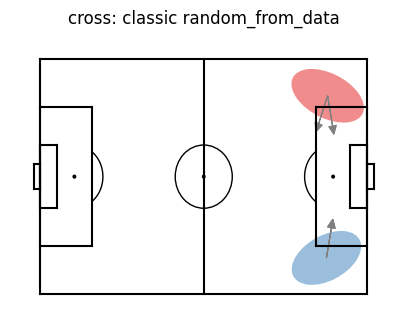

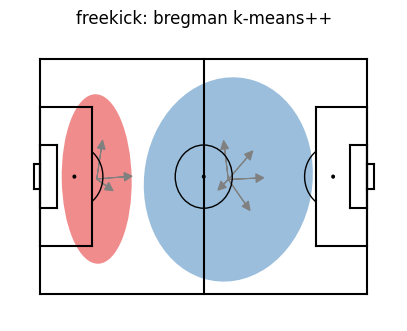

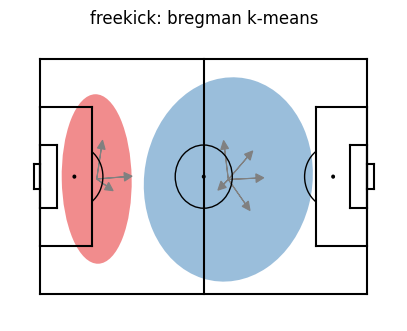

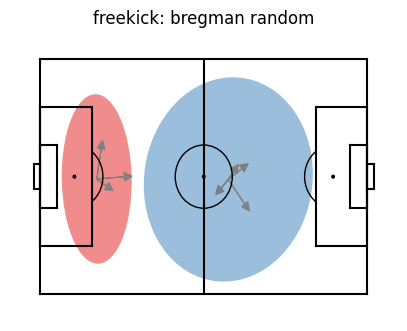

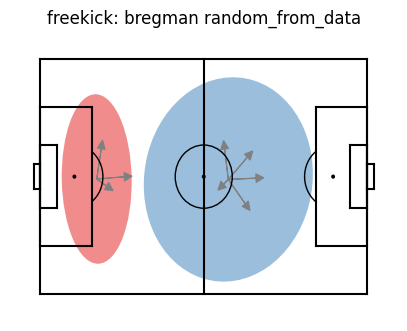

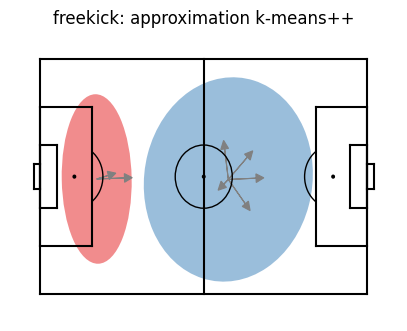

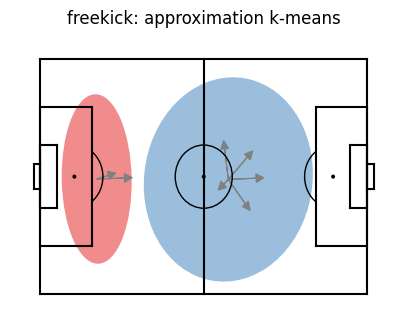

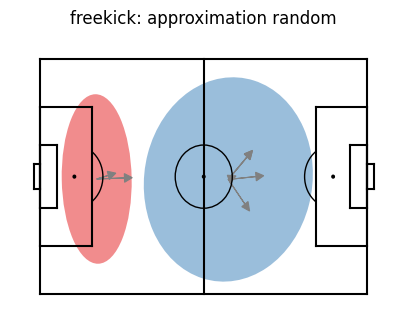

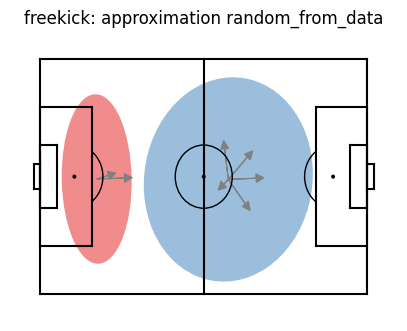

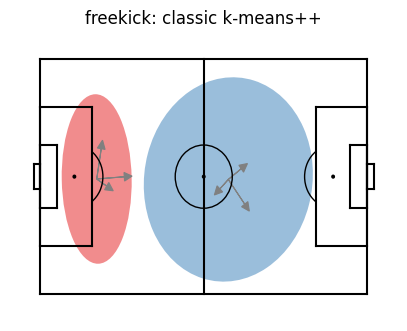

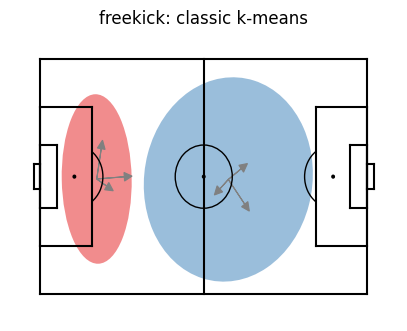

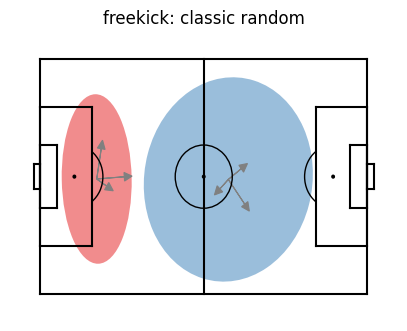

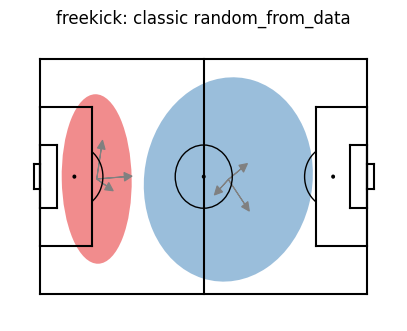

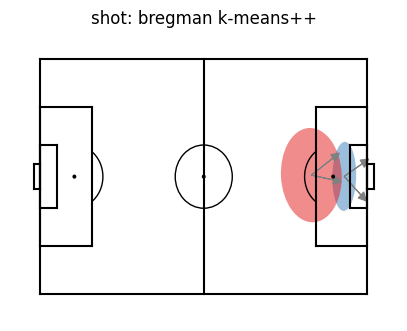

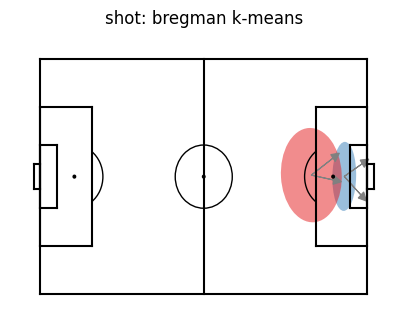

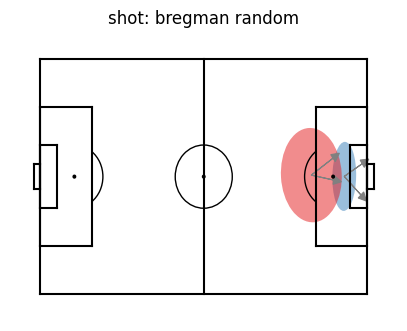

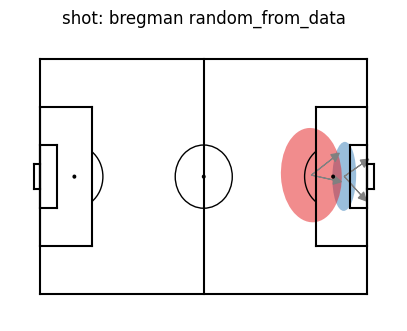

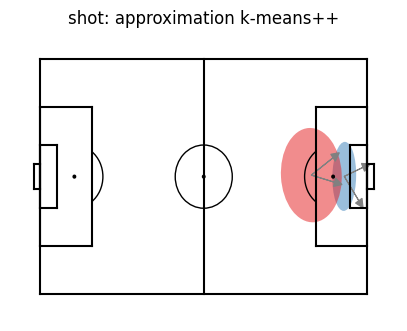

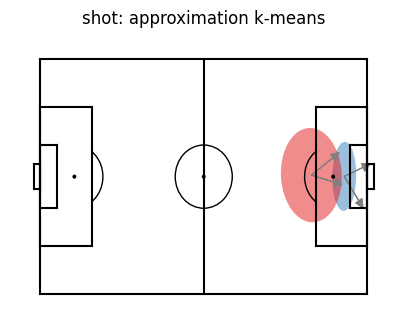

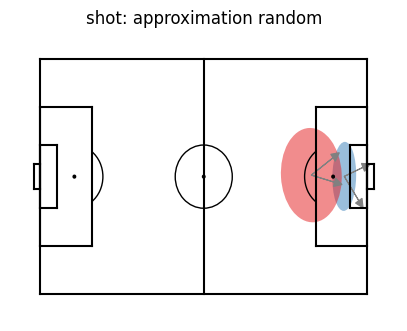

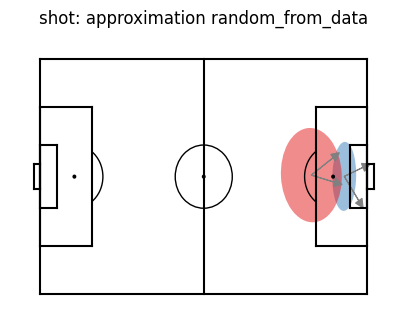

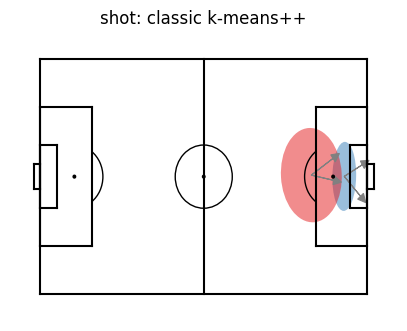

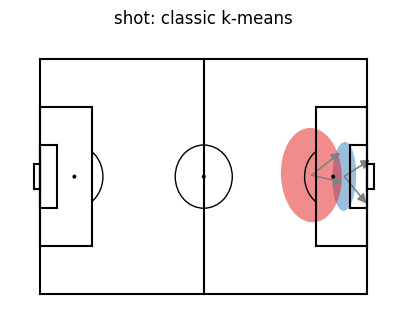

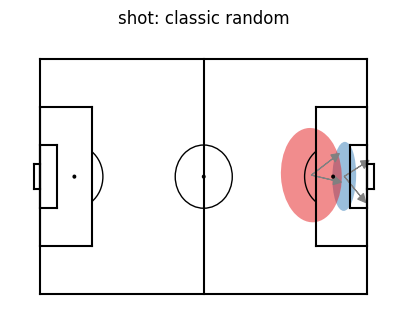

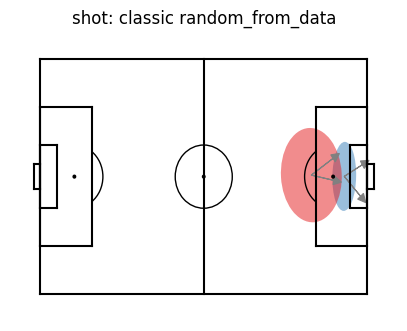

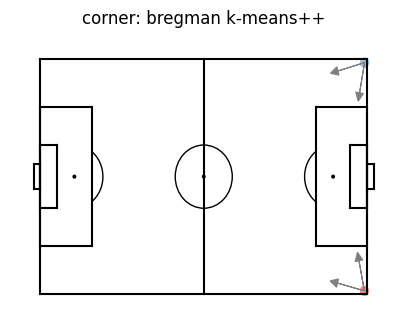

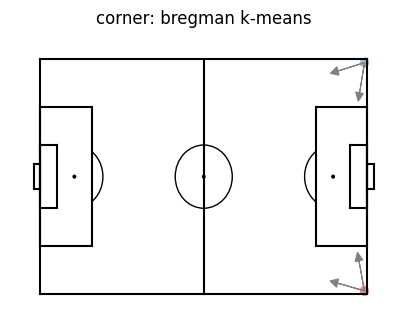

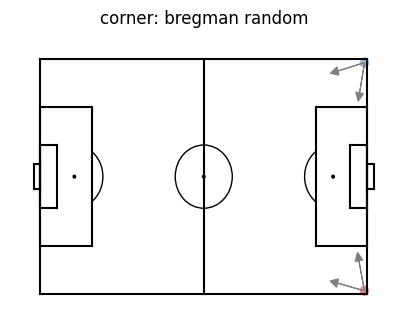

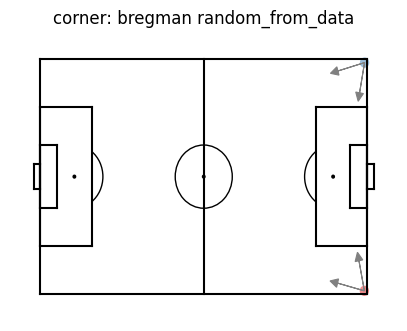

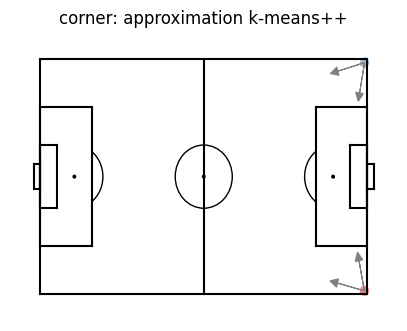

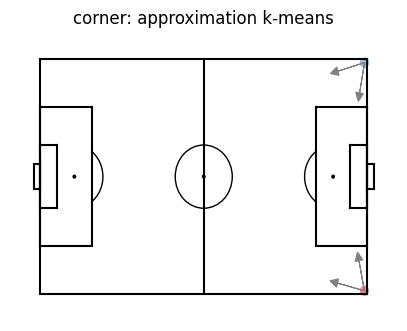

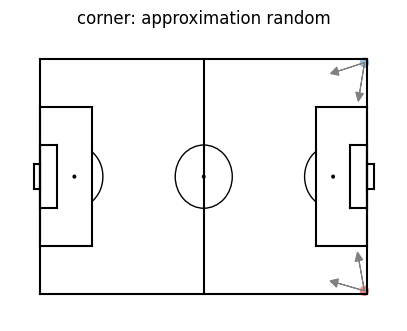

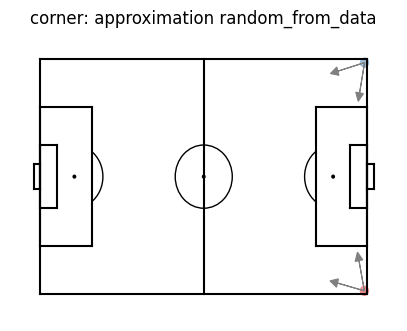

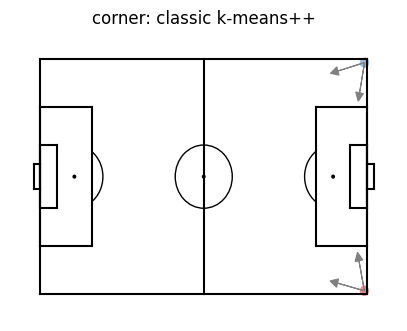

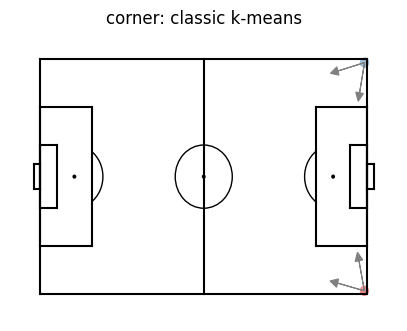

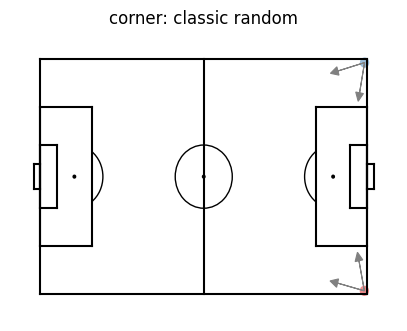

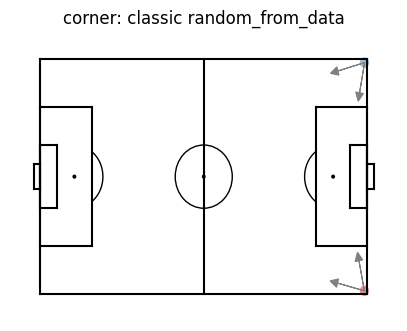

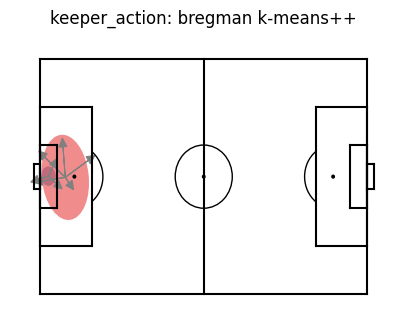

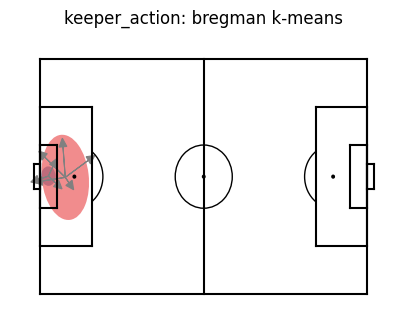

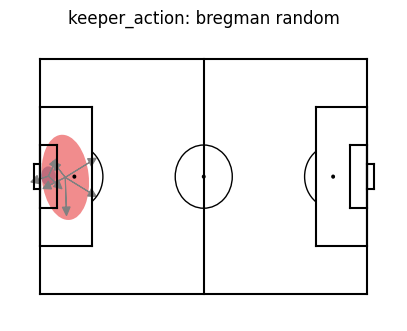

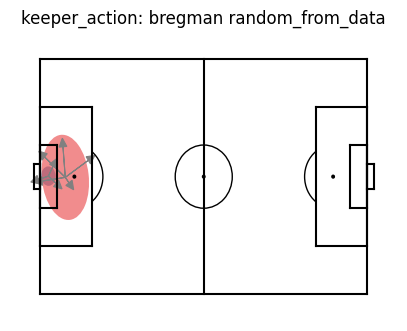

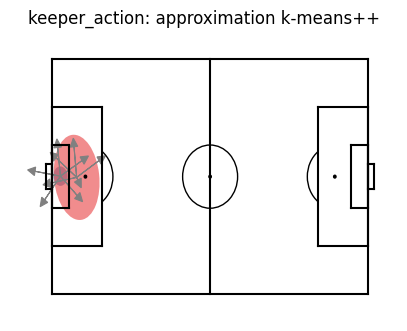

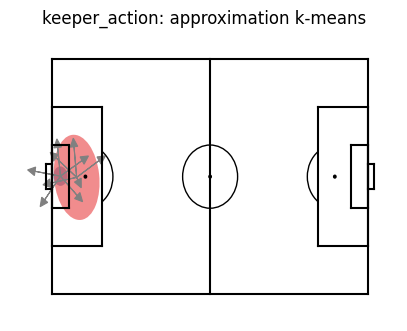

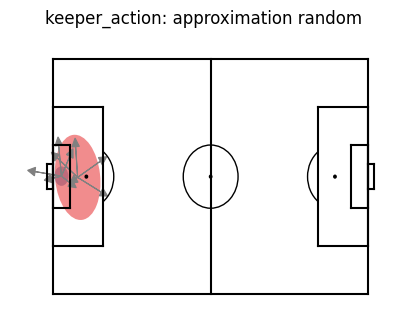

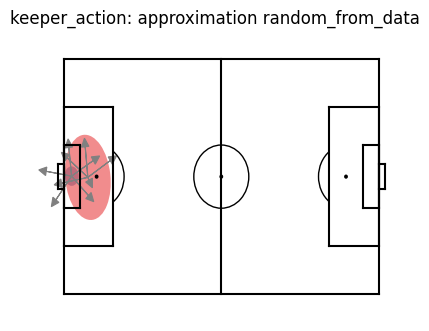

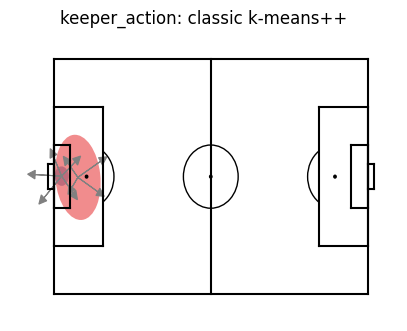

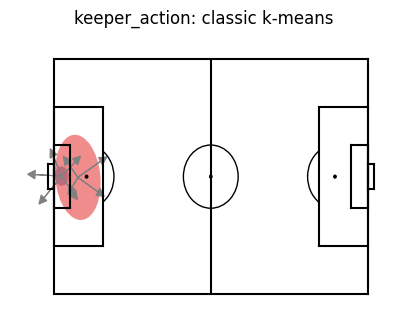

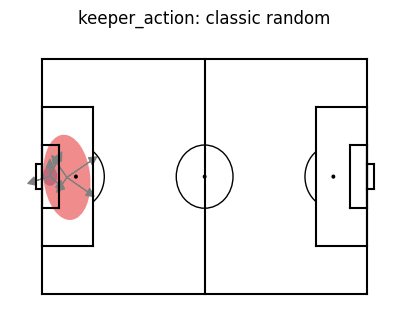

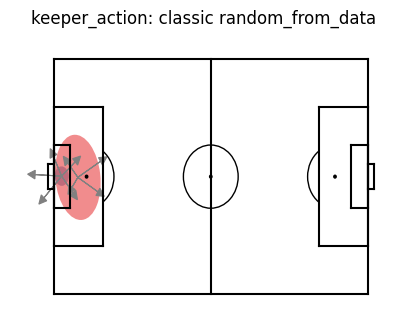

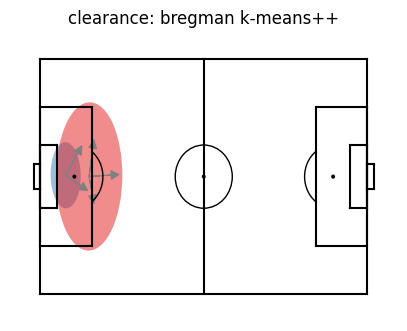

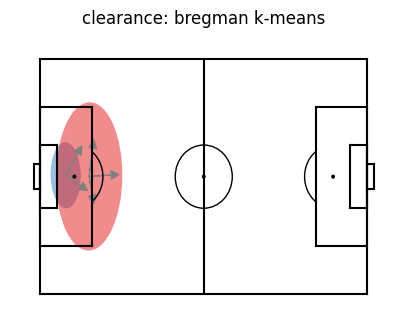

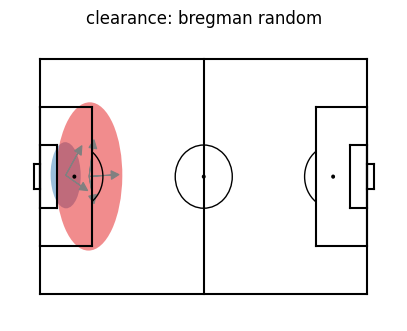

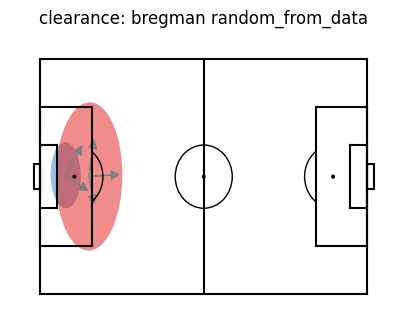

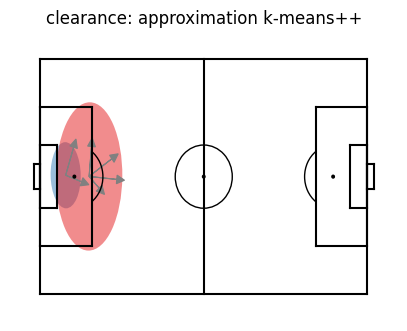

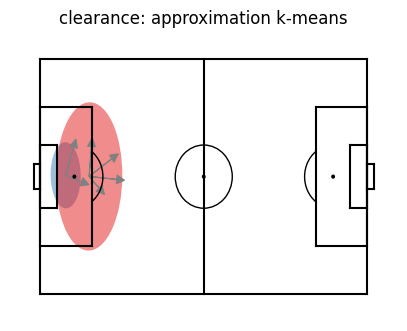

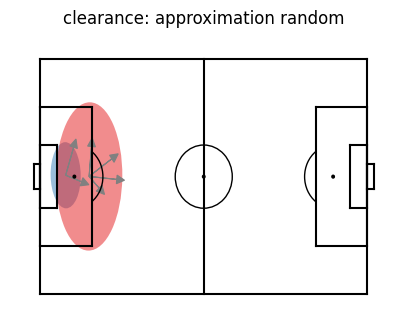

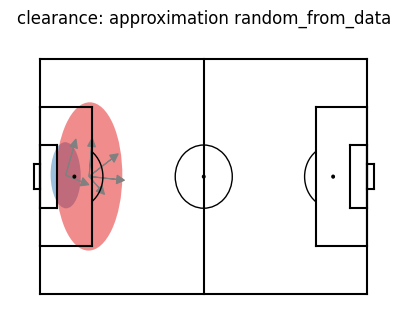

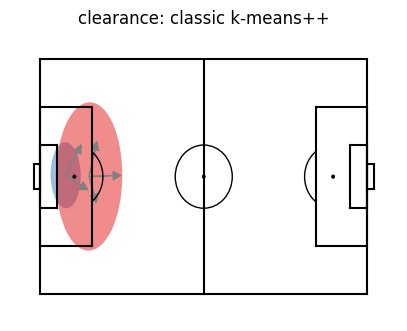

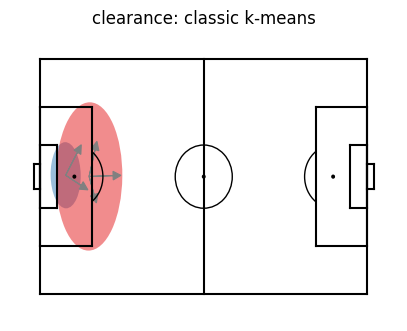

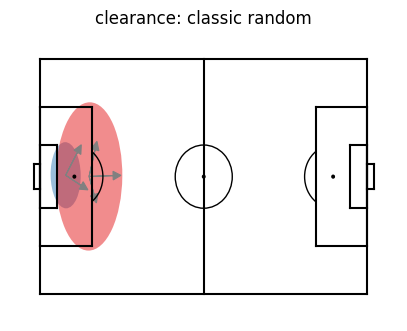

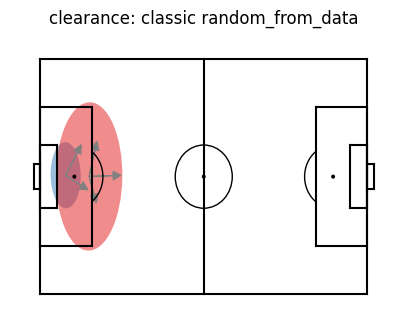

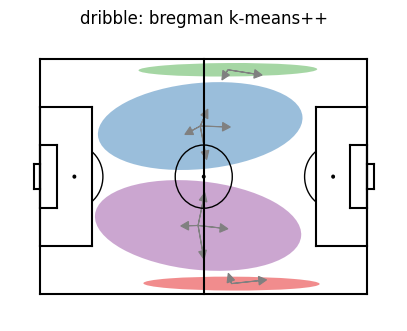

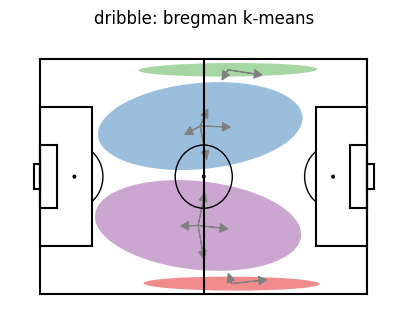

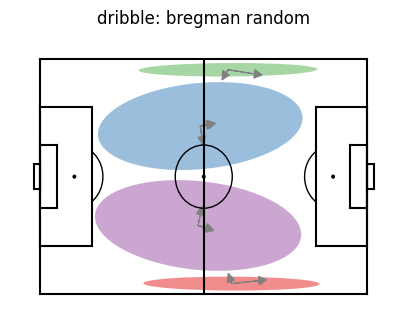

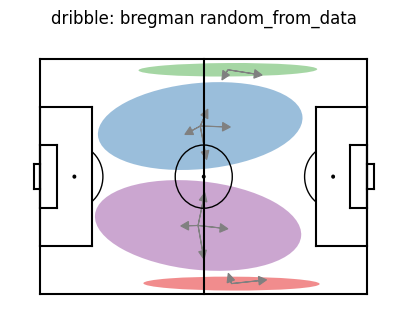

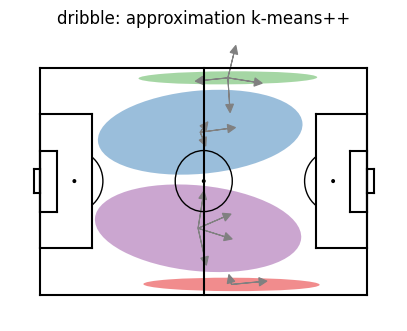

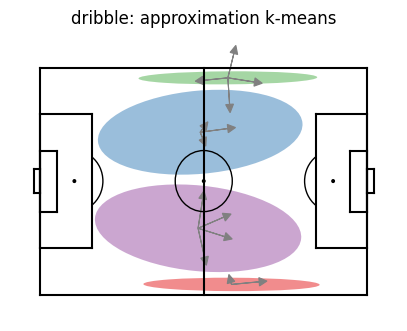

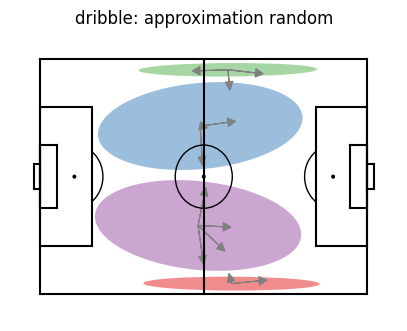

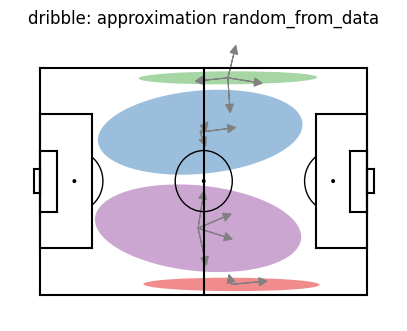

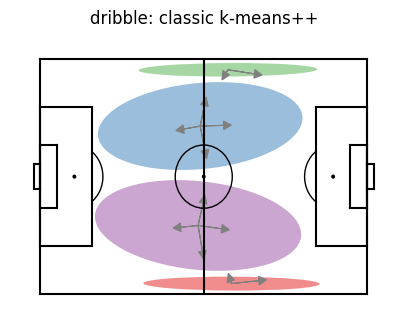

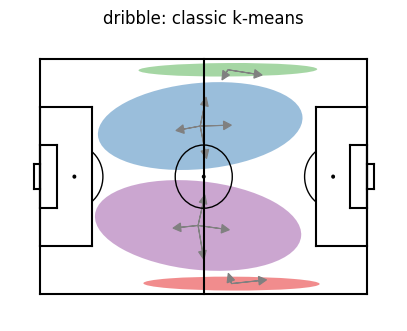

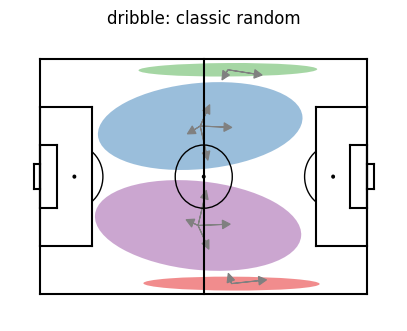

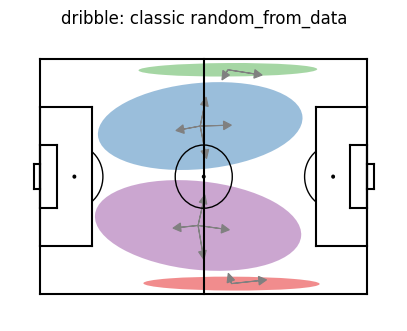

In [102]:
for action_type in action_types:
    for method in ["bregman","approximation","classic"]:
        for init in ["k-means++", "k-means", "random", "random_from_data"]:
            vis.show_all_models(loc_models[action_type],
                                experiment[method + "," + init][action_type],
                                title=f"{action_type}: {method} {init}",
                                figsize=5)